In [84]:
import numpy as np
import pandas as pd 
import torch
import numpy as np
import torchvision
import random
import matplotlib.pyplot as plt
from torchvision import transforms, models
from torch.utils.data import Dataset, TensorDataset, DataLoader
from PIL import Image
import PIL
import sys
from tqdm import tqdm
from scipy.misc import imresize
import warnings 
import keras
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Model
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.layers import add
from keras.layers import Dense
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Flatten
from keras.applications.vgg19 import VGG19
from keras.models import Model
warnings.filterwarnings('ignore')

In [164]:
# Источники:
# https://medium.com/@birla.deepak26/single-image-super-resolution-using-gans-keras-aca310f33112
# https://github.com/deepak112/Keras-SRGAN

In [13]:
# Принимает список изображений
# и предоставляет изображения HighResolution в виде массива numpy
def hr_images(images):
    images_hr = array(images)
    return images_hr

# Принимает список изображений 
# и предоставляет изображения LowResolution в виде массива numpy
def lr_images(images_real , downscale):   
    images = []
    for img in  range(len(images_real)):
        images.append(imresize(images_real[img], [images_real[img].shape[0]//downscale, images_real[img].shape[1]//downscale], interp='bicubic', mode=None))
    images_lr = array(images)
    return images_lr

In [14]:
# Residual block
def res_block_gen(model, kernal_size, filters, strides):    
    gen = model
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
    model = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(model)
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)   
    model = add([gen, model])
    return model
    
    
def up_sampling_block(model, kernal_size, filters, strides):
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = UpSampling2D(size = 2)(model)
    model = LeakyReLU(alpha = 0.2)(model)
    return model

def discriminator_block(model, filters, kernel_size, strides):
    model = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
    model = LeakyReLU(alpha = 0.2)(model)
    return model

In [15]:
class Generator(object):
    def __init__(self, noise_shape):
        self.noise_shape = noise_shape
        
    def generator(self):
        gen_input = Input(shape = self.noise_shape)
     
        model = Conv2D(filters = 64, kernel_size = 9, strides = 1, padding = "same")(gen_input)
        model = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(model)
        
        gen_model = model
    
        # Using 16 Residual Blocks
        for index in range(16):
            model = res_block_gen(model, 3, 64, 1)
     
        model = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "same")(model)
        model = BatchNormalization(momentum = 0.5)(model)
        model = add([gen_model, model])
     
        # Using 2 UpSampling Blocks
        for index in range(2):
            model = up_sampling_block(model, 3, 256, 1)
     
        model = Conv2D(filters = 3, kernel_size = 9, strides = 1, padding = "same")(model)
        model = Activation('tanh')(model)
    
        generator_model = Model(inputs = gen_input, outputs = model)
        return generator_model

In [16]:
class Discriminator(object):
    def __init__(self, image_shape):
        self.image_shape = image_shape
    
    def discriminator(self):
        dis_input = Input(shape = self.image_shape)
        
        model = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "same")(dis_input)
        model = LeakyReLU(alpha = 0.2)(model)
        
        model = discriminator_block(model, 64, 3, 2)
        model = discriminator_block(model, 128, 3, 1)
        model = discriminator_block(model, 128, 3, 2)
        model = discriminator_block(model, 256, 3, 1)
        model = discriminator_block(model, 256, 3, 2)
        model = discriminator_block(model, 512, 3, 1)
        model = discriminator_block(model, 512, 3, 2)
        
        model = Flatten()(model)
        model = Dense(1024)(model)
        model = LeakyReLU(alpha = 0.2)(model)
       
        model = Dense(1)(model)
        model = Activation('sigmoid')(model) 
        
        discriminator_model = Model(inputs = dis_input, outputs = model)
        
        return discriminator_model

In [17]:
def vgg_loss(y_true, y_pred):
    
    vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=image_shape)
    vgg19.trainable = False
    for l in vgg19.layers:
        l.trainable = False
    loss_model = Model(inputs=vgg19.input, outputs=vgg19.get_layer('block5_conv4').output)
    loss_model.trainable = False
    return K.mean(K.square(loss_model(y_true) - loss_model(y_pred)))

In [18]:
def get_gan_network(discriminator, shape, generator, optimizer):
    discriminator.trainable = False
    gan_input = Input(shape=shape)
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=[x,gan_output])
    gan.compile(loss=[vgg_loss, "binary_crossentropy"],
                loss_weights=[1., 1e-3],
                optimizer=optimizer)

    return gan

In [19]:
def get_optimizer():
    adam = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    return adam

In [20]:
# Better to use downscale factor as 4
downscale_factor = 4

# Remember to change image shape if you are having different size of images
image_shape = (384,384,3)

def train(epochs, batch_size, input_dir, output_dir, number_of_images, train_test_ratio):
    # Loads training and test data
    # Create custom function, where hr_images and lr_images function can be used to get high resolution and low resolution images
    x_train_lr, x_train_hr, x_test_lr, x_test_hr = load_training_data(input_dir, '.jpg', number_of_images, train_test_ratio) 
    
    batch_count = int(x_train_hr.shape[0] / batch_size)
    shape = (image_shape[0]//downscale_factor, image_shape[1]//downscale_factor, image_shape[2])
    
    generator = Generator(shape).generator()
    discriminator = Discriminator(image_shape).discriminator()

    optimizer = get_optimizer()
    generator.compile(loss=vgg_loss, optimizer=optimizer)
    discriminator.compile(loss="binary_crossentropy", optimizer=optimizer)
    
    gan = get_gan_network(discriminator, shape, generator, optimizer, vgg_loss)
    
    for e in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(batch_count)):
            
            rand_nums = np.random.randint(0, x_train_hr.shape[0], size=batch_size)
            
            image_batch_hr = x_train_hr[rand_nums]
            image_batch_lr = x_train_lr[rand_nums]
            generated_images_sr = generator.predict(image_batch_lr)

            real_data_Y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2
            fake_data_Y = np.random.random_sample(batch_size)*0.2
            
            discriminator.trainable = True
            
            d_loss_real = discriminator.train_on_batch(image_batch_hr, real_data_Y)
            d_loss_fake = discriminator.train_on_batch(generated_images_sr, fake_data_Y)
            discriminator_loss = 0.5 * np.add(d_loss_fake, d_loss_real)
            
            rand_nums = np.random.randint(0, x_train_hr.shape[0], size=batch_size)
            image_batch_hr = x_train_hr[rand_nums]
            image_batch_lr = x_train_lr[rand_nums]

            gan_Y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2
            discriminator.trainable = False
            gan_loss = gan.train_on_batch(image_batch_lr, [image_batch_hr,gan_Y])
            
            
        print("discriminator_loss : %f" % discriminator_loss)
        print("gan_loss :", gan_loss)
        gan_loss = str(gan_loss)
        
        if e == 1 or e % 10 == 0:
            Utils.plot_generated_images(output_dir, e, generator, x_test_hr, x_test_lr)
        if e % 500 == 0:
            generator.save(model_save_dir + 'gen_model%d.h5' % e)
            discriminator.save(model_save_dir + 'dis_model%d.h5' % e)

In [21]:
# Загружаем обученную сеть
reconstructed_model = keras.models.load_model("./gen_model3000.h5", custom_objects={"Generator": Generator, 'vgg_loss': vgg_loss})

In [23]:
reconstructed_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 96, 64)   15616       input_1[0][0]                    
__________________________________________________________________________________________________
p_re_lu_1 (PReLU)               (None, 96, 96, 64)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 96, 96, 64)   36928       p_re_lu_1[0][0]                  
____________________________________________________________________________________________

batch_normalization_12 (BatchNo (None, 96, 96, 64)   256         conv2d_13[0][0]                  
__________________________________________________________________________________________________
add_6 (Add)                     (None, 96, 96, 64)   0           add_5[0][0]                      
                                                                 batch_normalization_12[0][0]     
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 96, 96, 64)   36928       add_6[0][0]                      
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 96, 96, 64)   256         conv2d_14[0][0]                  
__________________________________________________________________________________________________
p_re_lu_8 (PReLU)               (None, 96, 96, 64)   64          batch_normalization_13[0][0]     
__________

__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 96, 96, 64)   36928       add_12[0][0]                     
__________________________________________________________________________________________________
batch_normalization_25 (BatchNo (None, 96, 96, 64)   256         conv2d_26[0][0]                  
__________________________________________________________________________________________________
p_re_lu_14 (PReLU)              (None, 96, 96, 64)   64          batch_normalization_25[0][0]     
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 96, 96, 64)   36928       p_re_lu_14[0][0]                 
__________________________________________________________________________________________________
batch_normalization_26 (BatchNo (None, 96, 96, 64)   256         conv2d_27[0][0]                  
__________

In [101]:
# Функции загрузки датасета
def to_categorical(y, num_classes=None, dtype='float32'):
    """
    Аналог from keras.utils.np_utils import to_categorical
    без использования keras.
    Источник - https://github.com/keras-team/keras/blob/master/keras/utils/np_utils.py#L9-L37
    """
    y = np.array(y, dtype='int')
    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])
    y = y.ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=dtype)
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical

def emotion_count(y_train, classes):
    """
    The function re-classify picture with disgust label into angry label
    """
    emo_classcount = {}
    #print ('Disgust classified as Angry')
    #y_train.loc[y_train == 1] = 0
    #classes.remove('Disgust') # Не удаляем седьмую эмоцию
    for new_num, _class in enumerate(classes):
        y_train.loc[(y_train == emotion[_class])] = new_num
        class_count = sum(y_train == (new_num))
        emo_classcount[_class] = (new_num, class_count)
    return y_train.values, emo_classcount

def load_data(sample_split=0.3, usage='Training',classes=['Angry','Happy'], filepath='./fer20131.csv'):
    """
    The function load provided CSV dataset and further reshape, rescale the data for feeding
    """
    df = pd.read_csv(filepath)
    df = df[df.Usage == usage]
    frames = []
    #classes.append('Disgust')
    for _class in classes:
        class_df = df[df['emotion'] == emotion[_class]]
        frames.append(class_df)
    data = pd.concat(frames, axis=0)
    rows = random.sample(list(data.index), int(len(data)*sample_split))
    data = data.loc[rows]
    x = list(data["pixels"])
    X = []
    for i in range(len(x)):
        each_pixel = [int(num) for num in x[i].split()]
        X.append(each_pixel)
    ## reshape into 48*48*1 and rescale
    X = np.array(X)
    X = X.reshape(X.shape[0], 48, 48,1)
    X = X.astype("float32")
    X /= 255
    
    y_train, new_dict = emotion_count(data.emotion, classes)
    y_train = to_categorical(y_train)
    return X, y_train

In [102]:
## Загрузка test,train,validation
emotion = {'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3,
           'Sad': 4, 'Surprise': 5, 'Neutral': 6}
# Добавляем удаленную в оригинале седьмую эмоцию (Disgust)
emo     = ['Angry', 'Disgust', 'Fear', 'Happy',
           'Sad', 'Surprise', 'Neutral']

X_test, y_test = load_data(sample_split=1.0,classes=emo,
usage='PrivateTest')

X_train, y_train = load_data(sample_split=1.0,classes=emo,
usage= 'Training')

X_val,y_val = load_data(sample_split=1.0,classes=emo,
usage= 'PublicTest')

In [150]:
add_chanels = lambda batch: np.repeat(batch, 3, -1)

def print_get_small_image(images_batch):
    images_batch = add_chanels(images_batch)
    size = images_batch.shape[0]
    result = np.zeros((size, 96, 96, 3))
    # Приводим к 96*96
    for b in range(size):
        for c in range(3):
            result[b, :48, :48, c] = images_batch[b, :, :, c]
            
    fig, axs = plt.subplots(1, size, figsize=(15,15))
    for plot in range(size):
        img = images_batch[plot]
        axs[plot].imshow(img)
    plt.show()
    return result

def print_get_predict_image(images_batch, h, w):
    size = images_batch.shape[0]
    model_predict = reconstructed_model.predict(images_batch)
    # Приводим к 200*200
    result = np.zeros((size, h, w, 3))
    for b in range(size):
        for c in range(3):
            result[b, :, :, c] = model_predict[b, :h, :w, c]
            
    fig, axs = plt.subplots(1, size, figsize=(15,15))
    for plot in range(size):
        img = result[plot]
        axs[plot].imshow(img)
    plt.show()
    return model_predict

# X_batch_test = X_test[0:5]
# оригинал
# original = print_get_small_image(X_batch_test)
# модель
# predicted = print_get_predict_image(original, 175, 175)

In [209]:
def print_compare_images(images_batch, scale = True):
    # обработка оригинальных
    images_batch = add_chanels(images_batch)
    size = images_batch.shape[0]
    original = np.zeros((size, 96, 96, 3))
    for b in range(size):
        for c in range(3):
            original[b, :48, :48, c] = images_batch[b, :, :, c]
            
    # обработка моделью
    h = 180
    w = 180
    model_predict = reconstructed_model.predict(original)
    predicted = np.zeros((size, h, w, 3))
    for b in range(size):
        for c in range(3):
            predicted[b, :, :, c] = model_predict[b, :h, :w, c]
            
    # отрисовка
    fig, axs = plt.subplots(size, 2, figsize=(10,20))
    for i in range(size):
        orig_img = images_batch[i]
        pred_img = predicted[i]
        axs[i, 0].imshow(orig_img)
        axs[i, 1].imshow(pred_img)
        # scale
        if scale:
            axs[i, 0].set_ylim([h, 0])
            axs[i, 0].set_xlim([0, w])
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


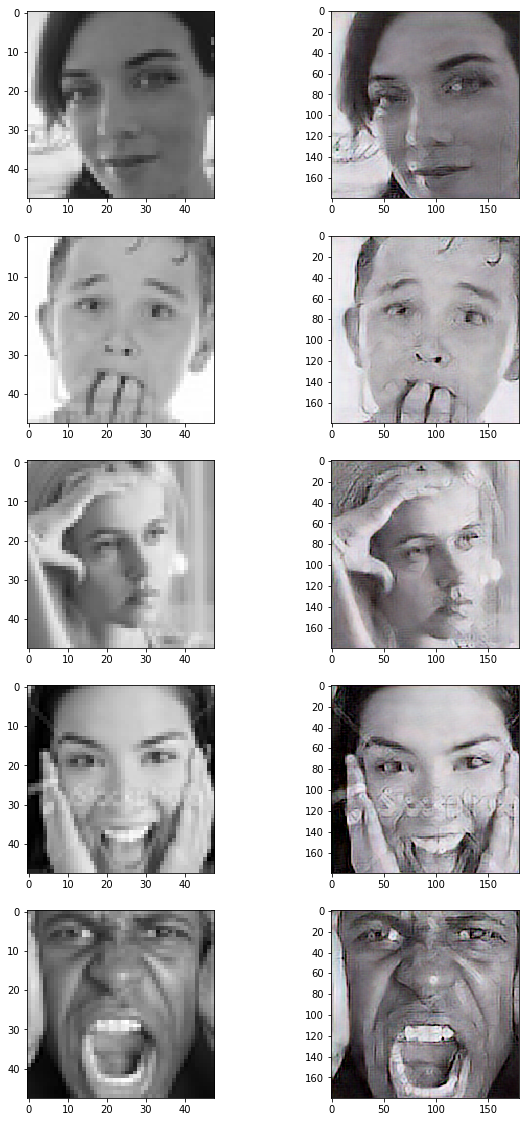

In [210]:
X_batch_test = X_test[10:15]
print_compare_images(X_batch_test, scale = False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


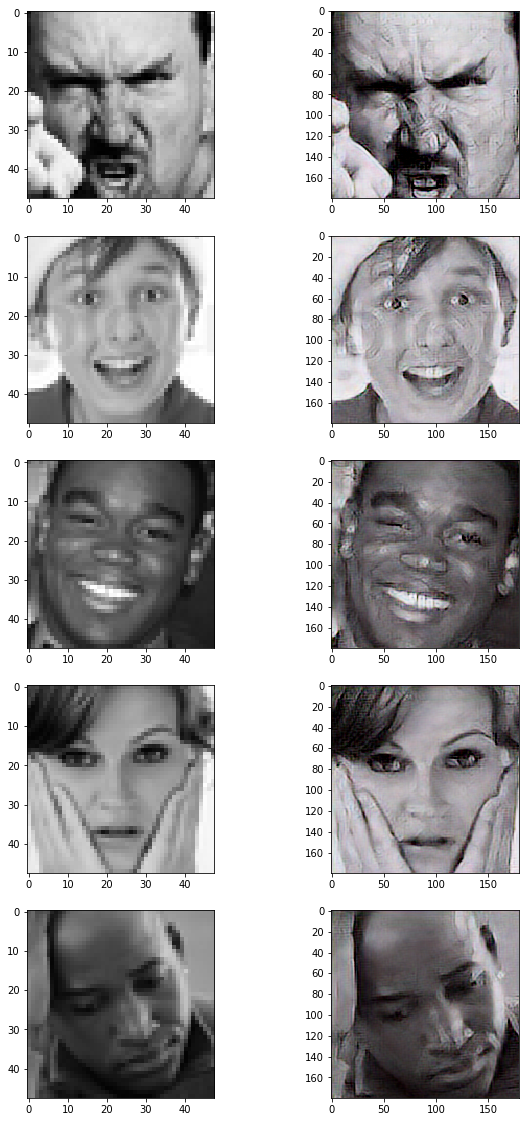

In [211]:
X_batch_test = X_test[25:30]
print_compare_images(X_batch_test, scale = False)